In [1]:
import itertools
import sys, os

from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from sklearn.metrics import classification_report, accuracy_score
#import sklearn.metrics as metrics
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import auc

from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from scipy import stats

In [2]:
sns.set_context("poster")

In [3]:
pd.set_option('max_colwidth', 100)

In [4]:
os.listdir('results')

['mit9313_SRR3334787_counts.csv.gz',
 'mit9313_SRR3334787_cover.csv.gz',
 'SRR3334788_counts.csv.gz',
 'SRR3334788_cover.csv.gz']

In [5]:
basename = 'mit9313_SRR3334787'
basename = 'SRR3334788'


In [6]:
count_df = pd.read_csv(os.path.join('results', f'{basename}_counts.csv.gz'))

In [7]:
cover_df = pd.read_csv(os.path.join('results', f'{basename}_cover.csv.gz'))

In [8]:
count_df.columns

Index(['Unnamed: 0', 'contig_id', 'gene_id', 'feature_id', 'type', 'location',
       'start', 'stop', 'strand', 'function', 'aliases', 'figfam',
       'evidence_codes', 'nucleotide_sequence', 'aa_sequence', 'min_idx',
       'max_idx', 'inter_stop_idx', 'inter_length', 'gene_length',
       'gene_is_reversed', 'reads', 'as_reads', 'reads_inter',
       'as_reads_inter'],
      dtype='object')

In [9]:
max_count_clip = 8000
count_df['clip_reads'] = count_df['reads'].clip(upper=max_count_clip)
count_df['clip_as_reads'] = count_df['as_reads'].clip(upper=max_count_clip)
count_df['clip_reads_inter'] = count_df['reads_inter'].clip(upper=max_count_clip)
count_df['clip_as_reads_inter'] = count_df['as_reads_inter'].clip(upper=max_count_clip)

In [10]:
short_max_length = 3*100
count_df['is_short'] = count_df['gene_length'] <= short_max_length
count_df['is_hypothetical'] = count_df['function'].str.contains(pat = 'hypothetical') 

In [11]:
count_df.head()

,Unnamed: 0,contig_id,gene_id,feature_id,type,location,start,stop,strand,function,...,reads,as_reads,reads_inter,as_reads_inter,clip_reads,clip_as_reads,clip_reads_inter,clip_as_reads_inter,is_short,is_hypothetical
0,0,MIT9313,PMIT9313_0001,fig|1218.91.peg.1,peg,MIT9313_174_1340,174,1340,+,DNA polymerase III beta subunit (EC 2.7.7.7),...,808,1210,0,0,808,1210,0,0,False,False
1,1,MIT9313,PMIT9313_0002,fig|1218.91.peg.2,peg,MIT9313_1368_2120,1368,2120,+,RNA metabolism-related protein,...,49,318,0,0,49,318,0,0,False,False
2,2,MIT9313,PMIT9313_0003,fig|1218.91.peg.3,peg,MIT9313_2160_4562,2160,4562,+,"Phosphoribosylformylglycinamidine synthase, synthetase subunit (EC 6.3.5.3)",...,329,673,0,1,329,673,0,1,False,False
3,3,MIT9313,PMIT9313_0004,fig|1218.91.peg.4,peg,MIT9313_4622_6079,4622,6079,+,Amidophosphoribosyltransferase (EC 2.4.2.14),...,178,399,0,0,178,399,0,0,False,False
4,4,MIT9313,PMIT9313_0005,fig|1218.91.peg.5,peg,MIT9313_8604_6115,8604,6115,-,DNA gyrase subunit A (EC 5.99.1.3),...,281,1038,11,0,281,1038,11,0,False,False


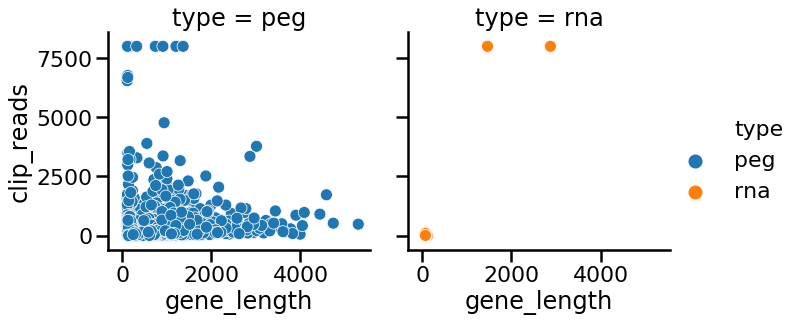

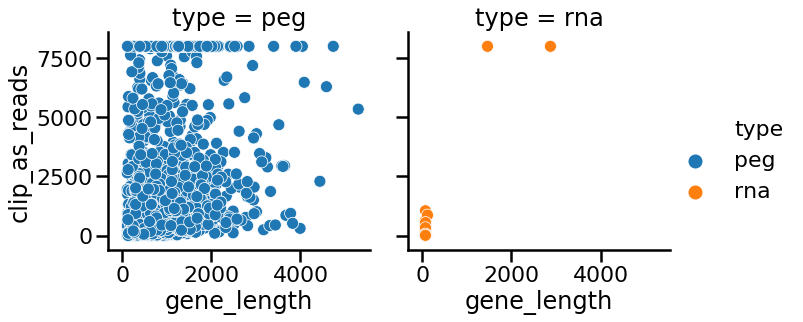

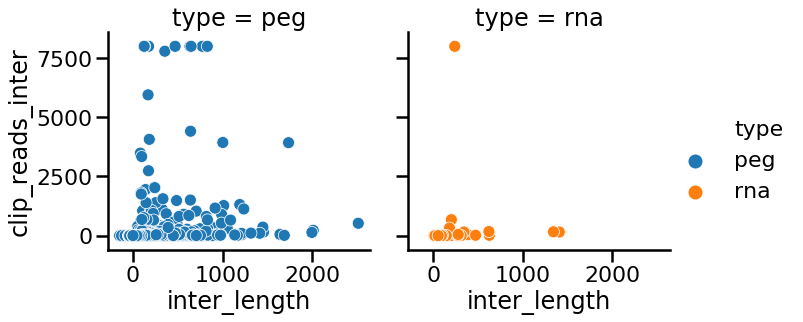

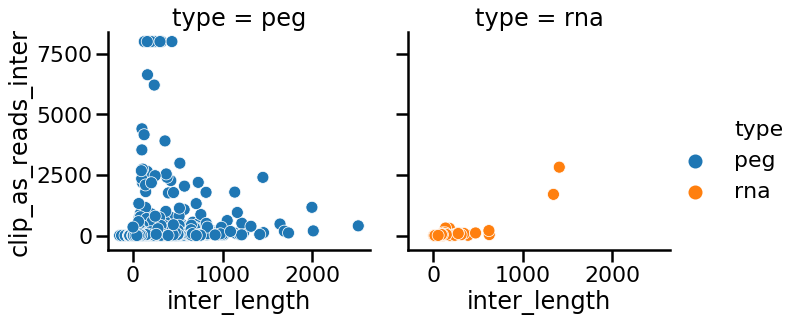

In [12]:
g = sns.relplot(data=count_df, x='gene_length', y='clip_reads', col='type', hue='type')
g = sns.relplot(data=count_df, x='gene_length', y='clip_as_reads', col='type', hue='type')
g = sns.relplot(data=count_df, x='inter_length', y='clip_reads_inter', col='type', hue='type')
g = sns.relplot(data=count_df, x='inter_length', y='clip_as_reads_inter', col='type', hue='type')

#g.set(yscale='log')

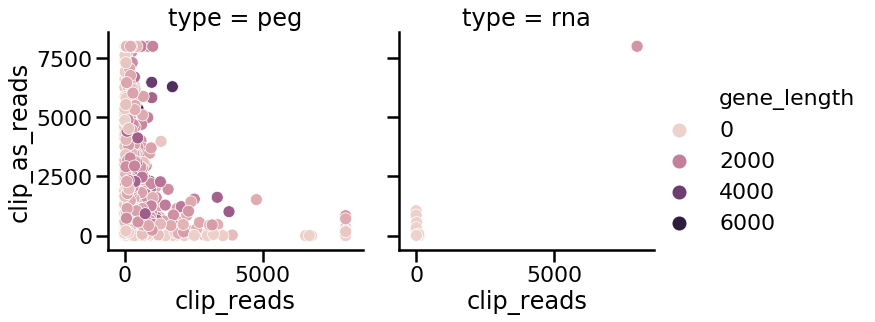

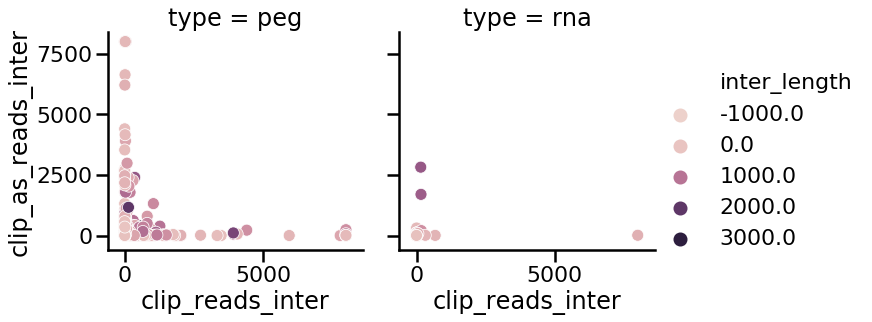

In [14]:
g = sns.relplot(data=count_df, hue='gene_length', x='clip_reads', y='clip_as_reads', col='type')
g = sns.relplot(data=count_df, hue='inter_length', x='clip_reads_inter', y='clip_as_reads_inter', col='type')

#g.set(yscale='log')

In [15]:
count_df.groupby('type')[['inter_length', 'gene_length']].describe().T

type                        peg          rna
inter_length count  2993.000000    51.000000
             mean    116.920815   189.235294
             std     193.301334   282.470359
             min    -149.000000     8.000000
             25%       8.000000    35.000000
             50%      56.000000   107.000000
             75%     148.000000   204.000000
             max    2513.000000  1408.000000
gene_length  count  2993.000000    51.000000
             mean    681.122619   240.549020
             std     618.720384   602.610697
             min     113.000000    70.000000
             25%     188.000000    71.000000
             50%     497.000000    73.000000
             75%     995.000000    81.000000
             max    5297.000000  2876.000000

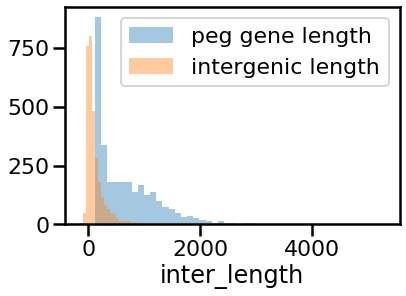

In [16]:
sns.distplot(count_df.loc[count_df.type == 'peg','gene_length'], kde=False, label='peg gene length')
#sns.distplot(count_df.loc[count_df.type == 'rna','gene_length'], kde=False, label='rna gene length')

sns.distplot(count_df.inter_length, kde=False, label='intergenic length')
plt.legend()

In [31]:
113/3

37.666666666666664

In [33]:
300/3

100.0

In [17]:
count_df.loc[count_df.clip_reads == max_count_clip]

,Unnamed: 0,contig_id,gene_id,feature_id,type,location,start,stop,strand,function,...,reads,as_reads,reads_inter,as_reads_inter,clip_reads,clip_as_reads,clip_reads_inter,clip_as_reads_inter,is_short,is_hypothetical
211,211,MIT9313,NaN,fig|1218.91.rna.3,rna,MIT9313_208864_210328,208864,210328,+,Small Subunit Ribosomal RNA; ssuRNA; SSU rRNA,...,15620,17508,5,297,8000,8000,5,297,False,False
215,215,MIT9313,NaN,fig|1218.91.rna.6,rna,MIT9313_211158_214034,211158,214034,+,Large Subunit Ribosomal RNA; lsuRNA; LSU rRNA,...,11754,35218,0,52,8000,8000,0,52,False,False
884,884,MIT9313,PMIT9313_0871,fig|1218.91.peg.871,peg,MIT9313_742764_743972,742764,743972,+,NAD binding site,...,9792,339,0,0,8000,339,0,0,False,False
973,973,MIT9313,PMIT9313_0958,fig|1218.91.peg.958,peg,MIT9313_832281_833648,832281,833648,+,Chloride channel protein-related protein,...,15878,845,208,0,8000,845,208,0,False,False
1361,1361,MIT9313,PMIT9313_1343,fig|1218.91.peg.1343,peg,MIT9313_1082336_1082151,1082336,1082151,-,hypothetical protein,...,13977,6,0,3532,8000,6,0,3532,True,True
1620,1620,MIT9313,PMIT9313_1600,fig|1218.91.peg.1600,peg,MIT9313_1272346_1272188,1272346,1272188,-,FIG00944368: hypothetical protein,...,18475,6,0,194,8000,6,0,194,True,True
2248,2248,MIT9313,NaN,fig|1218.91.rna.33,rna,MIT9313_1751330_1748454,1751330,1748454,-,Large Subunit Ribosomal RNA; lsuRNA; LSU rRNA,...,11565,35334,675,6,8000,8000,675,6,False,False
2252,2252,MIT9313,NaN,fig|1218.91.rna.36,rna,MIT9313_1753624_1752160,1753624,1752160,-,Small Subunit Ribosomal RNA; ssuRNA; SSU rRNA,...,15156,17369,10461,11,8000,8000,8000,11,False,False
2386,2386,MIT9313,PMIT9313_2350,fig|1218.91.peg.2350,peg,MIT9313_1841362_1841243,1841362,1841243,-,FIG00942270: hypothetical protein,...,8355,0,0,0,8000,0,0,0,True,True
2448,2448,MIT9313,PMIT9313_2410,fig|1218.91.peg.2410,peg,MIT9313_1897320_1898111,1897320,1898111,+,Protein involved in meta-pathway of phenol degradation,...,8379,240,1559,24,8000,240,1559,24,False,False


In [18]:
count_df.loc[count_df.clip_as_reads == max_count_clip]

,Unnamed: 0,contig_id,gene_id,feature_id,type,location,start,stop,strand,function,...,reads,as_reads,reads_inter,as_reads_inter,clip_reads,clip_as_reads,clip_reads_inter,clip_as_reads_inter,is_short,is_hypothetical
54,54,MIT9313,PMIT9313_0054,fig|1218.91.peg.54,peg,MIT9313_52126_50930,52126,50930,-,Sulfolipid (UDP-sulfoquinovose) biosynthesis protein,...,124,10884,24,0,124,8000,24,0,False,False
72,72,MIT9313,PMIT9313_0072,fig|1218.91.peg.72,peg,MIT9313_65217_63778,65217,63778,-,Cell division trigger factor (EC 5.2.1.8),...,268,8855,4,18,268,8000,4,18,False,False
76,76,MIT9313,PMIT9313_0076,fig|1218.91.peg.76,peg,MIT9313_67501_69432,67501,69432,+,"Zn-dependent hydrolase, RNA-metabolising",...,359,10161,0,0,359,8000,0,0,False,False
92,92,MIT9313,PMIT9313_0092,fig|1218.91.peg.92,peg,MIT9313_87244_87741,87244,87741,+,"6,7-dimethyl-8-ribityllumazine synthase (EC 2.5.1.78)",...,79,8201,48,55,79,8000,48,55,False,False
95,95,MIT9313,PMIT9313_0094,fig|1218.91.peg.94,peg,MIT9313_88626_91472,88626,91472,+,Protein export cytoplasm protein SecA ATPase RNA helicase (TC 3.A.5.1.1),...,523,8588,49,75,523,8000,49,75,False,False
102,102,MIT9313,PMIT9313_0101,fig|1218.91.peg.101,peg,MIT9313_99535_101931,99535,101931,+,PROBABLE HEMAGGLUTININ-RELATED PROTEIN,...,64,16365,0,0,64,8000,0,0,False,False
155,155,MIT9313,PMIT9313_0154,fig|1218.91.peg.154,peg,MIT9313_157203_158624,157203,158624,+,Adenosylhomocysteinase (EC 3.3.1.1),...,536,14304,0,0,536,8000,0,0,False,False
203,203,MIT9313,PMIT9313_0202,fig|1218.91.peg.202,peg,MIT9313_202344_201982,202344,201982,-,Photosystem II 12 kDa extrinsic protein (PsbU),...,33,26558,53,19,33,8000,53,19,False,False
211,211,MIT9313,NaN,fig|1218.91.rna.3,rna,MIT9313_208864_210328,208864,210328,+,Small Subunit Ribosomal RNA; ssuRNA; SSU rRNA,...,15620,17508,5,297,8000,8000,5,297,False,False
215,215,MIT9313,NaN,fig|1218.91.rna.6,rna,MIT9313_211158_214034,211158,214034,+,Large Subunit Ribosomal RNA; lsuRNA; LSU rRNA,...,11754,35218,0,52,8000,8000,0,52,False,False


C:\Users\wosnat\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1741: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


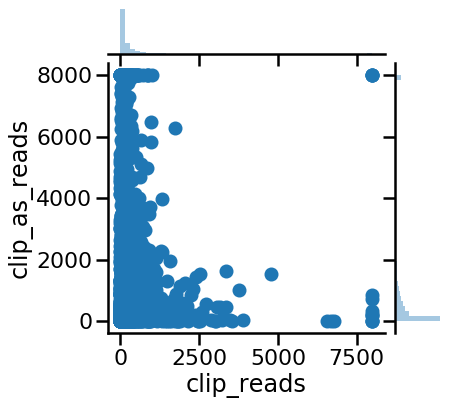

In [19]:
sns.jointplot(count_df.clip_reads, count_df.clip_as_reads)

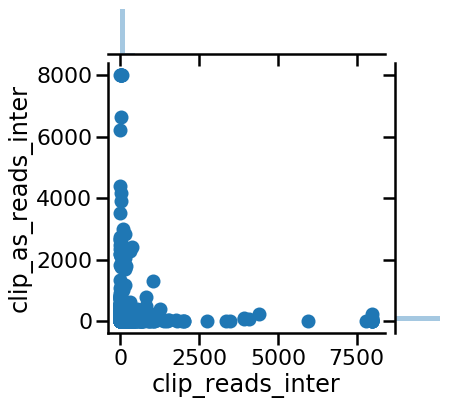

In [21]:
sns.jointplot(count_df.clip_reads_inter, count_df.clip_as_reads_inter)

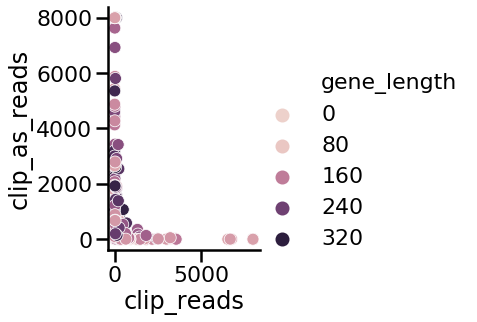

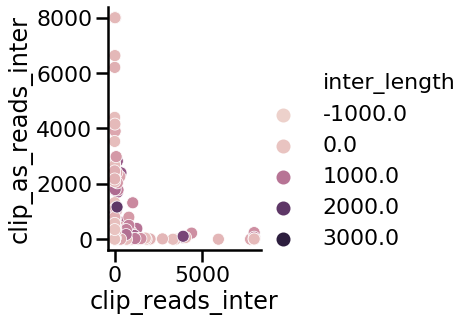

In [22]:
g = sns.relplot(data=count_df.loc[count_df.is_short], hue='gene_length', x='clip_reads', y='clip_as_reads')
g = sns.relplot(data=count_df, hue='inter_length', x='clip_reads_inter', y='clip_as_reads_inter')


In [23]:
count_df.loc[(count_df.clip_reads == max_count_clip) & count_df.is_short]

,Unnamed: 0,contig_id,gene_id,feature_id,type,location,start,stop,strand,function,...,reads,as_reads,reads_inter,as_reads_inter,clip_reads,clip_as_reads,clip_reads_inter,clip_as_reads_inter,is_short,is_hypothetical
1361,1361,MIT9313,PMIT9313_1343,fig|1218.91.peg.1343,peg,MIT9313_1082336_1082151,1082336,1082151,-,hypothetical protein,...,13977,6,0,3532,8000,6,0,3532,True,True
1620,1620,MIT9313,PMIT9313_1600,fig|1218.91.peg.1600,peg,MIT9313_1272346_1272188,1272346,1272188,-,FIG00944368: hypothetical protein,...,18475,6,0,194,8000,6,0,194,True,True
2386,2386,MIT9313,PMIT9313_2350,fig|1218.91.peg.2350,peg,MIT9313_1841362_1841243,1841362,1841243,-,FIG00942270: hypothetical protein,...,8355,0,0,0,8000,0,0,0,True,True


In [20]:
cover_df.columns

Index(['Unnamed: 0', 'contig_id', 'gene_id', 'type', 'location', 'gene_inter',
       'peg_sense', 'peg_as', 'rna_sense', 'rna_as', 'reads', 'reads_as',
       'overflow_reads', 'overflow_reads_as'],
      dtype='object')

In [24]:
def get_gene_cover(gene_idx, window):
    #gene_id = 'PMIT9313_1343'
    idx = gene_idx
    fmt_id = 'PMIT9313_{idx}'
    start_location = count_df.loc[count_df.gene_id == fmt_id.format(idx=idx - window), 'min_idx'].min()
    stop_location = count_df.loc[count_df.gene_id == fmt_id.format(idx=idx +window), 'inter_stop_idx'].max()
    df = cover_df.loc[(cover_df.location >= start_location) & (cover_df.location < stop_location) ]
    return df


In [27]:
df = get_gene_cover(1361, 2)

In [29]:
 
df.location.max() - df.location.min(), df.location.max(),df.location.min()

(1563, 1087936, 1086373)

In [30]:
df.shape

(1564, 15)

In [60]:
count_df.loc[count_df.gene_id.isin(['PMIT9313_1342', 'PMIT9313_1343', 'PMIT9313_1344'])].T

,1360,1361,1362
Unnamed: 0,1360,1361,1362
contig_id,MIT9313,MIT9313,MIT9313
gene_id,PMIT9313_1342,PMIT9313_1343,PMIT9313_1344
feature_id,fig|1218.91.peg.1342,fig|1218.91.peg.1343,fig|1218.91.peg.1344
type,peg,peg,peg
location,MIT9313_1082094_1081930,MIT9313_1082336_1082151,MIT9313_1082435_1082875
start,1082094,1082336,1082435
stop,1081930,1082151,1082875
strand,-,-,+
function,FIG00943660: hypothetical protein,hypothetical protein,FIG00942715: hypothetical protein


In [31]:
df.head()

,Unnamed: 0,contig_id,gene_id,type,location,gene_inter,inter_sense,peg_sense,peg_as,rna_sense,rna_as,reads,reads_as,overflow_reads,overflow_reads_as
900264,900264,MIT9313,PMIT9313_1359,peg,1086373,NaN,NaN,NaN,1.0,NaN,NaN,0,0,9,0
900265,900265,MIT9313,PMIT9313_1359,peg,1086374,NaN,NaN,NaN,1.0,NaN,NaN,0,0,9,0
900266,900266,MIT9313,PMIT9313_1359,peg,1086375,NaN,NaN,NaN,1.0,NaN,NaN,0,0,9,0
900267,900267,MIT9313,PMIT9313_1359,peg,1086376,NaN,NaN,NaN,1.0,NaN,NaN,0,0,9,0
900268,900268,MIT9313,PMIT9313_1359,peg,1086377,NaN,NaN,NaN,1.0,NaN,NaN,0,0,9,0


In [32]:
df.columns

Index(['Unnamed: 0', 'contig_id', 'gene_id', 'type', 'location', 'gene_inter',
       'inter_sense', 'peg_sense', 'peg_as', 'rna_sense', 'rna_as', 'reads',
       'reads_as', 'overflow_reads', 'overflow_reads_as'],
      dtype='object')

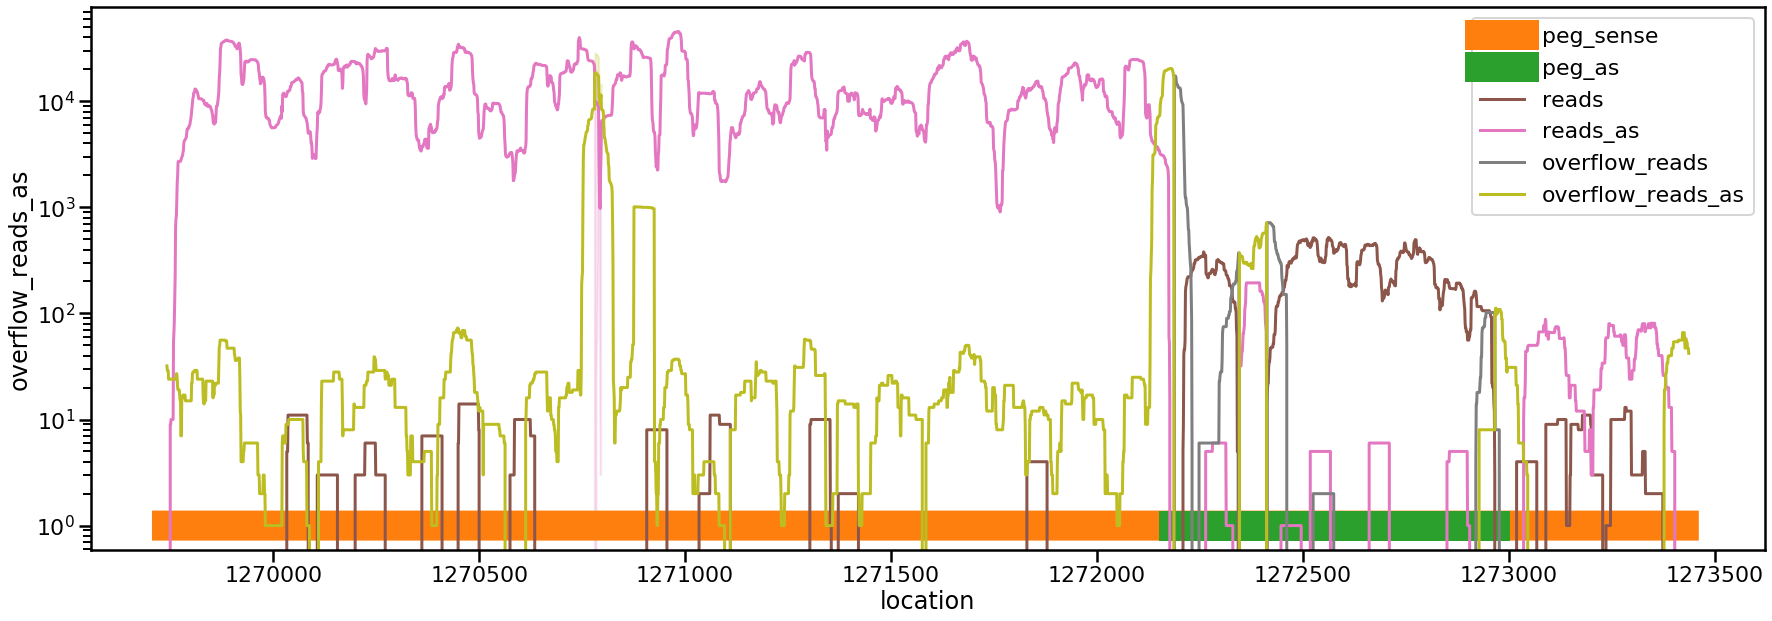

In [38]:
plt.figure(figsize=(30,10))
for i in ['gene_inter', 'peg_sense', 'peg_as', 'rna_sense', 'rna_as',]:
    sns.lineplot(df.location, df[i], label=i, linewidth=30)
for i in [ 'reads', 'reads_as', 'overflow_reads', 'overflow_reads_as']:
    sns.lineplot(df.location, df[i], label=i)
plt.yscale('log')

In [34]:
df = get_gene_cover(1600, window=2)

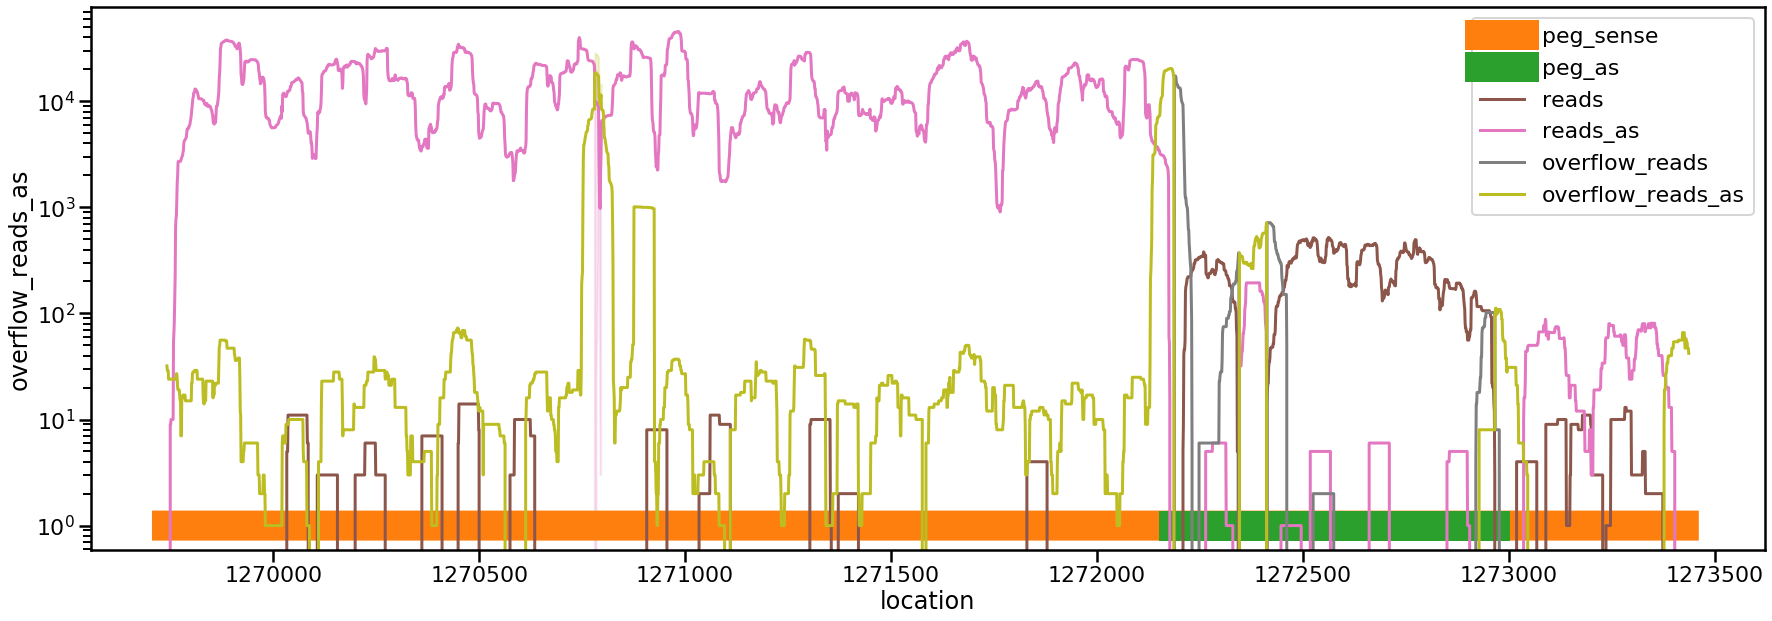

In [35]:
plt.figure(figsize=(30,10))
for i in ['gene_inter', 'peg_sense', 'peg_as', 'rna_sense', 'rna_as',]:
    sns.lineplot(df.location, df[i], label=i, linewidth=30)
for i in [ 'reads', 'reads_as', 'overflow_reads', 'overflow_reads_as']:
    sns.lineplot(df.location, df[i], label=i)
plt.yscale('log')

In [43]:
df = get_gene_cover(1620, window=0)

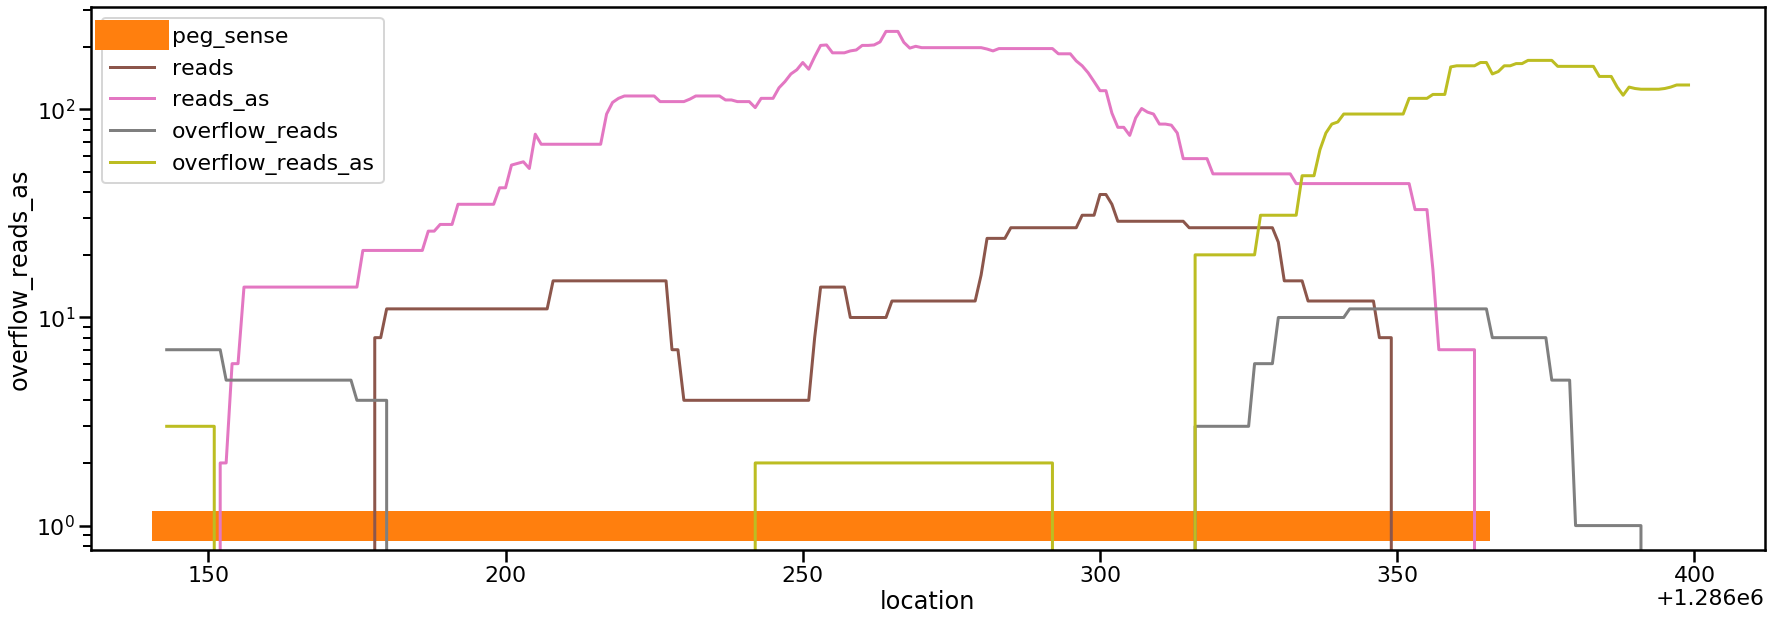

In [44]:
plt.figure(figsize=(30,10))
for i in ['gene_inter', 'peg_sense', 'peg_as', 'rna_sense', 'rna_as',]:
    sns.lineplot(df.location, df[i], label=i, linewidth=30)
for i in [ 'reads', 'reads_as', 'overflow_reads', 'overflow_reads_as']:
    sns.lineplot(df.location, df[i], label=i)
plt.yscale('log')

In [64]:
df = get_gene_cover(1620, window=2)

In [65]:
df.loc[df.peg_as.isna(), 'peg_as'] = 0
df.loc[df.peg_sense.isna(), 'peg_sense'] = 0

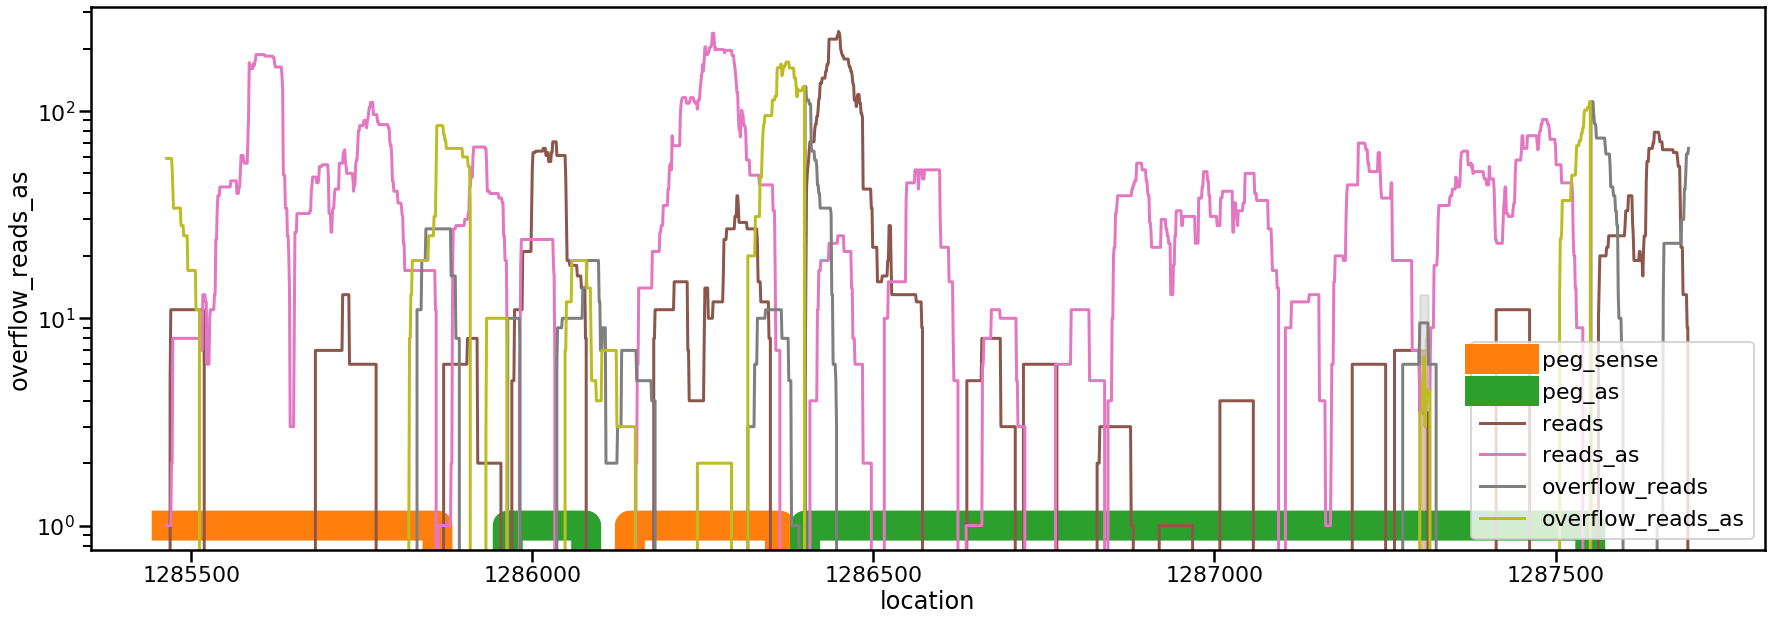

In [66]:
plt.figure(figsize=(30,10))
for i in ['gene_inter', 'peg_sense', 'peg_as', 'rna_sense', 'rna_as',]:
    sns.lineplot(df.location, df[i], label=i, linewidth=30)
    #plt.show()
for i in [ 'reads', 'reads_as', 'overflow_reads', 'overflow_reads_as']:
    sns.lineplot(df.location, df[i], label=i)
plt.yscale('log')

In [36]:
cover_df.describe()

,Unnamed: 0,location,gene_inter,inter_sense,peg_sense,peg_as,rna_sense,rna_as,reads,reads_as,overflow_reads,overflow_reads_as
count,2.398021e+06,2.398021e+06,0.0,359421.0,1068168.0,970432.0,0.0,0.0,2.398021e+06,2.398021e+06,2.398021e+06,2.398021e+06
mean,1.199010e+06,1.206043e+06,NaN,1.0,1.0,1.0,NaN,NaN,2.537705e+01,1.751760e+02,5.448264e+00,1.560606e+01
std,6.922492e+05,6.958874e+05,NaN,0.0,0.0,0.0,NaN,NaN,5.815275e+02,1.405590e+03,1.811159e+02,3.039947e+02
min,0.000000e+00,1.740000e+02,NaN,1.0,1.0,1.0,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.995050e+05,6.043860e+05,NaN,1.0,1.0,1.0,NaN,NaN,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00
50%,1.199010e+06,1.204026e+06,NaN,1.0,1.0,1.0,NaN,NaN,2.000000e+00,2.200000e+01,0.000000e+00,0.000000e+00
75%,1.798515e+06,1.811683e+06,NaN,1.0,1.0,1.0,NaN,NaN,1.100000e+01,6.700000e+01,0.000000e+00,0.000000e+00
max,2.398020e+06,2.410872e+06,NaN,1.0,1.0,1.0,NaN,NaN,7.697500e+04,7.365500e+04,4.584600e+04,4.584600e+04


In [37]:
cover_df.location.max(), cover_df.location.min(), cover_df.location.max() - cover_df.location.min(), 

(2410872, 174, 2410698)

In [57]:
df.loc[(df.peg_sense == 10), 'peg_as'].unique()

array([nan])